<a href="https://colab.research.google.com/github/sfwtopoulos/stocks/blob/master/Stocks_seq_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import math
import warnings
import numpy as np
import time

import pandas_datareader as pdr
#%tensorflow_version 2.x
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 1.x
import tensorflow as tf
import keras


from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [134]:
print(keras.__version__)
print(tf.__version__)
#print(tensorflow.compat.v2.__version__)

2.2.5
1.15.0


In [0]:
#Data import from git repo
url = 'https://raw.githubusercontent.com/sfwtopoulos/stocks/master/stocks_dataset/combined.csv'
#df1 = pd.read_csv(url, error_bad_lines=False)
dfstocks = pd.read_csv(url, sep=',')

In [136]:
#fix column names
dfstocks=dfstocks.rename({' AAPL':'Company', ' Close/Last':'Close', ' Volume':'Volume', ' Open':'Open', ' High':'High', ' Low':'Low'}, axis=1);
for col in dfstocks.columns: 
    print(col) 

Date
Close
Volume
Open
High
Low
Company


In [0]:
#drop $sign from values
dfstocks.Close=dfstocks['Close'].astype(str)
dfstocks.Close=dfstocks.Close.apply(lambda x: x.replace('$',''))
dfstocks.Open=dfstocks['Open'].astype(str)
dfstocks.Open=dfstocks.Open.apply(lambda x: x.replace('$',''))
dfstocks.High=dfstocks['High'].astype(str)
dfstocks.High=dfstocks.High.apply(lambda x: x.replace('$',''))
dfstocks.Low=dfstocks['Low'].astype(str)
dfstocks.Low=dfstocks.Low.apply(lambda x: x.replace('$',''))

In [138]:
#drop rows containing nan or header from the csv files
dfstocks=dfstocks[~dfstocks.Low.str.contains("nan")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("Low")]
dfstocks=dfstocks[~dfstocks.Low.str.contains("N/A")]
dfstocks=dfstocks[~dfstocks.Volume.str.contains("N/A")]
dfstocks.reset_index(drop=True, inplace=True)
dfstocks.Date.count()

229269

In [139]:
#sort dataframe based on date and Company Name
dfstocks = dfstocks.sort_values(['Date', 'Company'])
dfstocks.head(100)

,Date,Close,Volume,Open,High,Low,Company
1761,01/02/2013,78.4328,139906732,79.1171,79.2857,77.3757,AAPL
4248,01/02/2013,35.12,13767660,34.92,35.4,34.1,ABBV
6025,01/02/2013,32.05,20266410,32.3,32.45,31.64,ABT
8512,01/02/2013,69.06,4039095,67.59,69.06,67.55,ACN
10999,01/02/2013,38.34,6483720,37.92,38.73,37.92,ADBE
...,...,...,...,...,...,...,...
10747,01/02/2014,59.29,2745895,59.06,59.53,58.94,ADBE
13234,01/02/2014,168.05,1268722,167.33,170.71,166.5937,AGN
15721,01/02/2014,50.71,9196092,50.81,51.3,50.47,AIG
18208,01/02/2014,53.55,1909106,54.09,54.45,53.5,ALL


In [140]:
#Converting Datatypes
dfstocks.Date=pd.to_datetime(dfstocks.Date)
dfstocks.Close=pd.to_numeric(dfstocks.Close)
dfstocks.Volume=pd.to_numeric(dfstocks.Volume)
dfstocks.Open=pd.to_numeric(dfstocks.Open)
dfstocks.High=pd.to_numeric(dfstocks.High)
dfstocks.Low=pd.to_numeric(dfstocks.Low)
dfstocks.dtypes

Date       datetime64[ns]
Close             float64
Volume              int64
Open              float64
High              float64
Low               float64
Company            object
dtype: object

In [141]:
#dfstocks[dfstocks['Company'].str.contains("AMZN")]
sub_split=dfstocks[dfstocks['Company'].str.contains("AAPL")]
sub_split.isnull().values.any()
sub_split.isna().values.any()
sub_split = sub_split.sort_values(['Date'])
sub_split.reset_index(drop=True, inplace=True)
sub_split.shape[0]

2487

In [142]:
sub_split

,Date,Close,Volume,Open,High,Low,Company
0,2010-02-16,29.0571,135631411,28.8486,29.0986,28.7886,AAPL
1,2010-02-17,28.9357,108691903,29.1700,29.1871,28.6943,AAPL
2,2010-02-18,28.9897,105298302,28.8043,29.1271,28.7028,AAPL
3,2010-02-19,28.8100,103810451,28.8371,29.0286,28.7300,AAPL
4,2010-02-22,28.6308,97607889,28.9057,28.9286,28.4557,AAPL
...,...,...,...,...,...,...,...
2482,2019-12-24,284.2700,12119710,284.6900,284.8900,282.9197,AAPL
2483,2019-12-26,289.9100,23334000,284.8200,289.9800,284.7000,AAPL
2484,2019-12-27,289.8000,36592940,291.1200,293.9700,288.1200,AAPL
2485,2019-12-30,291.5200,36059610,289.4600,292.6900,285.2200,AAPL


In [0]:
# prepare training and testing data sets for LSTM based sequence modeling
#def dimitris_function(time_series, scaling=True,split_ratio=0.9):
def dimitris_function(time_series,split_ratio=0.9):

    series1 = pd.Series(time_series[time_series.columns[0]])
    series2 = pd.Series(time_series[time_series.columns[1]])
    series3 = pd.Series(time_series[time_series.columns[2]])
    series4 = pd.Series(time_series[time_series.columns[3]])
    series5 = pd.Series(time_series[time_series.columns[4]])

    values1 = series1.values
    values1 = values1.reshape((len(values1), 1))
    values2 = series2.values
    values2 = values2.reshape((len(values2), 1))
    values3 = series3.values
    values3 = values3.reshape((len(values3), 1))
    values4 = series4.values
    values4 = values4.reshape((len(values4), 1))
    values5 = series5.values
    values5 = values5.reshape((len(values5), 1))

    #scaler2 --> Close Price Scaler
    scaler1 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled1"] = scaler1.fit_transform(values1)
    scaler2 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled2"]= scaler2.fit_transform(values2)
    scaler3 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled3"]= scaler3.fit_transform(values3)
    scaler4 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled4"]= scaler4.fit_transform(values4)
    scaler5 = MinMaxScaler(feature_range=(0, 1))
    time_series["scaled5"]= scaler5.fit_transform(values5)


    time_series = time_series[["scaled1","scaled2","scaled3","scaled4","scaled5"]].values

        
    split_ratio = int(len(time_series) * split_ratio)

    train = time_series[0:split_ratio]
    test = time_series[split_ratio:len(time_series)]
    
    # return train,test,scaler1,scaler2
    return train,test,scaler2


In [0]:
def get_seq_model(hidden_units=4,input_shape=(1,1)):
    # create and fit the LSTM network
    model = Sequential()
    # samples*timesteps*features
    # https://keras.io/getting-started/sequential-model-guide/
    #relu_advanced=keras.activations.relu(x,)
    model.add(LSTM(input_shape=input_shape,
                   units = hidden_units,  
   #                activation='relu',
                   return_sequences=True
    ))

    # readout layer. TimeDistributedDense uses the same weights for all
    # time steps.
    # model.add(TimeDistributed(Dense(1))) #number of inputs in the 1st layer
    model.add(TimeDistributed(Dense(5)))   
    start = time.time()
    
    model.compile(loss="mse", optimizer="rmsprop")

    print("> Compilation Time : ", time.time() - start)
    print(model.summary())

    return model

In [0]:
# print(type(sub_split.Close))
sub_split_date=sub_split[['Date']]
sub_split=sub_split[['Volume', 'Close', 'Open', 'High', 'Low']]
#sub_split.columns[1]

In [146]:
# split train and test datasets
train,test,scaler_Close = dimitris_function(sub_split,split_ratio=0.7)

#train
print(len(train))
print(train.shape[0])
print(train.shape)
print(test.shape)
print(train)

1740
1740
(1740, 5)
(747, 5)
[[0.27549278 0.00341169 0.00247791 0.00127145 0.00317325]
 [0.21577058 0.00295444 0.00370032 0.00160515 0.00281272]
 [0.2082473  0.00315783 0.00230942 0.00137891 0.00284522]
 ...
 [0.04890092 0.34214367 0.34136585 0.34187655 0.34401636]
 [0.02897624 0.34259565 0.34448464 0.34168801 0.34539271]
 [0.03567232 0.34500621 0.34437054 0.34376185 0.34653967]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [147]:
#We use numpy to reshape our time series into 3D tensors.
train = np.reshape(train,(1,train.shape[0],5))
test = np.reshape(test,(1,test.shape[0],5))

train_x = train[:,:-1,:]
train_y = train[:,1:,:]

test_x = test[:,:-1,:]
test_y = test[:,1:,:]

print("Data Split Complete")

print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))
print("test_x shape={}".format(test_x.shape))
print("test_y shape={}".format(test_y.shape))

Data Split Complete
train_x shape=(1, 1739, 5)
train_y shape=(1, 1739, 5)
test_x shape=(1, 746, 5)
test_y shape=(1, 746, 5)


In [148]:
# build RNN model
seq_lstm_model=None
try:
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],5))
except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],5))

> Compilation Time :  0.01949453353881836
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1739, 4)           160       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1739, 5)           25        
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________
None


In [149]:
train_y

array([[[0.21577058, 0.00295444, 0.00370032, 0.00160515, 0.00281272],
        [0.2082473 , 0.00315783, 0.00230942, 0.00137891, 0.00284522],
        [0.20494889, 0.00248099, 0.00243417, 0.00100751, 0.00294921],
        ...,
        [0.04890092, 0.34214367, 0.34136585, 0.34187655, 0.34401636],
        [0.02897624, 0.34259565, 0.34448464, 0.34168801, 0.34539271],
        [0.03567232, 0.34500621, 0.34437054, 0.34376185, 0.34653967]]])

In [0]:
# train the model
seq_lstm_model.fit(train_x, train_y,
                #epochs=20, batch_size=1,
                epochs=250, batch_size=1,
                verbose=1)
print("Model Fit Complete")

In [151]:
# train fit performance
trainPredict = seq_lstm_model.predict(train_x)
trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.04 RMSE


In [152]:
trainPredict

array([[[ 0.17144215,  0.03537476,  0.03596097, -0.01906215,
          0.0475629 ],
        [ 0.18560989,  0.03689206,  0.03068619, -0.00465292,
          0.05142184],
        [ 0.1955903 ,  0.03821465,  0.02523692,  0.00575709,
          0.05418438],
        ...,
        [ 0.07836381,  0.34154528,  0.33902943,  0.32061774,
          0.3536402 ],
        [ 0.0782306 ,  0.3423293 ,  0.3418454 ,  0.32135278,
          0.35382515],
        [ 0.07707612,  0.3431349 ,  0.34486443,  0.3218258 ,
          0.35545418]]], dtype=float32)

In [0]:
# Pad input sequence
testPredict = pad_sequences(test_x,maxlen=train_x.shape[1],padding='post',dtype='float64')

In [154]:
# forecast values
testPredict = seq_lstm_model.predict(testPredict)
testPredict

array([[[ 0.12593752,  0.07701878,  0.1416097 , -0.00052318,
          0.08597989],
        [ 0.11490497,  0.11757374,  0.21451019,  0.04507636,
          0.12509789],
        [ 0.11164216,  0.1554589 ,  0.26448894,  0.09272703,
          0.16003011],
        ...,
        [ 0.12640475,  0.04977996, -0.00355513, -0.01642536,
          0.1144051 ],
        [ 0.12640475,  0.04977996, -0.00355513, -0.01642536,
          0.1144051 ],
        [ 0.12640475,  0.04977996, -0.00355513, -0.01642536,
          0.1144051 ]]], dtype=float32)

In [0]:
#Drop all other variables except Close Price Output
testPredict=np.delete(testPredict, [2,3,4], 2)
trainPredict=np.delete(trainPredict, [2,3,4], 2)
# testPredict=np.delete(testPredict, 3, 2)
# trainPredict=np.delete(trainPredict, 3, 2)
# testPredict=np.delete(testPredict, 4, 2)
# trainPredict=np.delete(trainPredict, 4, 2)
testPredict=np.delete(testPredict, 0, 2)
trainPredict=np.delete(trainPredict, 0, 2)

In [156]:
testPredict

array([[[0.07701878],
        [0.11757374],
        [0.1554589 ],
        ...,
        [0.04977996],
        [0.04977996],
        [0.04977996]]], dtype=float32)

In [157]:
trainPredict


array([[[0.03537476],
        [0.03689206],
        [0.03821465],
        ...,
        [0.34154528],
        [0.3423293 ],
        [0.3431349 ]]], dtype=float32)

In [158]:
type(testPredict)

numpy.ndarray

In [0]:
# # inverse transformation of the Close Price
trainPredict = scaler_Close.inverse_transform(trainPredict.\
                                        reshape(-1,1))
testPredict = scaler_Close.inverse_transform(testPredict.\
                                       reshape(-1,1))

In [160]:
trainPredict

array([[ 37.54325 ],
       [ 37.946095],
       [ 38.29724 ],
       ...,
       [118.83113 ],
       [119.03928 ],
       [119.253174]], dtype=float32)

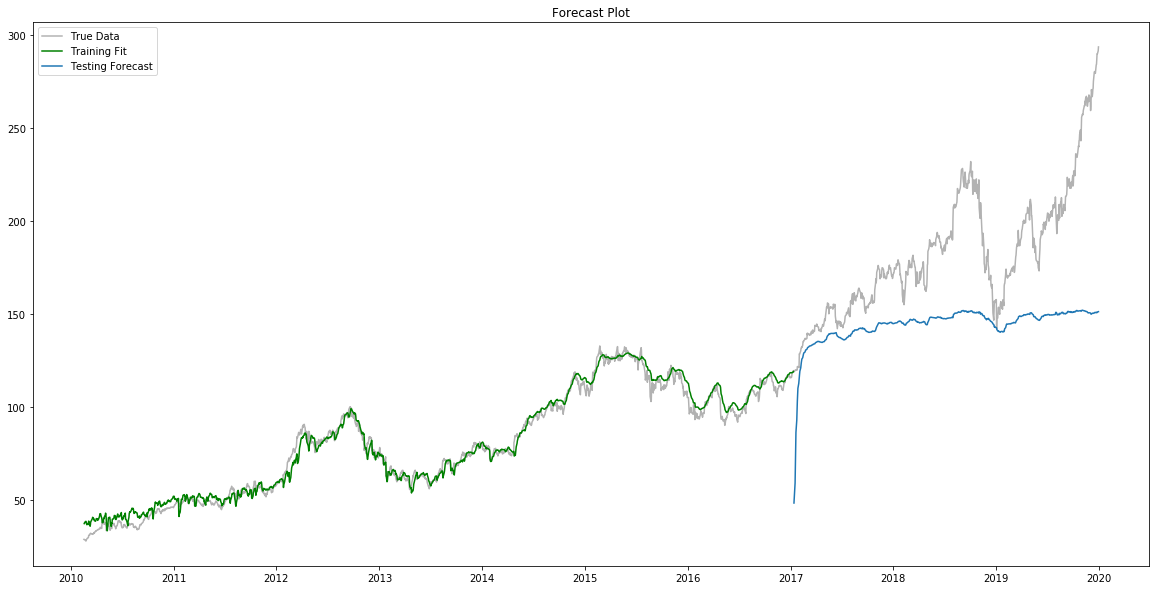

In [161]:
# plot the true and forecasted values
split_ratio = len(trainPredict)+1

plt.plot(sub_split_date.Date,
          sub_split.Close.values,c='black',
          alpha=0.3,label='True Data')

plt.plot(sub_split_date.Date[1:split_ratio],
          trainPredict,label='Training Fit',c='g')

plt.plot(sub_split_date.Date[split_ratio+1:],
          testPredict[:test_x.shape[1]],label='Testing Forecast')
plt.title('Forecast Plot')
plt.legend()
#plt.show()
plt.rcParams["figure.figsize"] = (20,10)
plt.show()